### Regression analysis
In this notebook regression analysis of the price of bitcoin is evaluated. The dataset is analyzed in the _data\_analysis_ file which contains all the details. The following features are taken into account:
- the total number of confirmed transactions per day 
- google search trends
- SP500 index value 
- gold price 


Time period for the data is between 01.2014 and 04.2020

The other features are either not correlated with the price of bitcoin or strongly connected with each other (what could lead to an incorrect model).
The dataset is divided into two subsets: a training set (80%) and a test set (20%). The training set is used for training a model. Evaluation of the model is carried out by calculating _root mean squared error_ (RMSE), $ R^2$ factor and by plotting residual plots.  

$$ RMSE = \sqrt{\frac{(y_1 - \hat{y_1})^2 + ... + ( y_n - \hat{y_n})^2}{n}} $$

where:
- $y$ - true price <br>
- $\hat{y}$ - predicted price
- $n$ - number of observations in a dataset

Because the price of bitcoin has been changing significantly over the time, the more reliable parameter is percentage error of the prediction:

$$ \epsilon_{percentage} = \frac{Price_{true} - Price_{predicted}}{Price_{true}} $$

Therefore this error is evaluated as well

In [138]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

__Loading the dataset__

In [139]:
data=pd.read_csv('data_cleaning\Bitcoin_dataset_updated.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')
data.fillna(method='ffill',inplace=True)
data.head()

,BTC price [USD],n-transactions,fee [USD],btc search trends,Gold price[USD],SP500 close index,Oil WTI price[USD],M2(Not seasonally adjusted)[1e+09 USD]
Date,,,,,,,,
2014-01-02,749.27,54770.0,0.18,8,1225.0,1831.98,95.14,11089.3
2014-01-03,781.23,60980.0,0.18,8,1238.4,1831.37,93.66,11089.3
2014-01-04,807.39,52052.0,0.18,8,1238.4,1831.37,93.66,11089.3
2014-01-05,828.74,58662.0,0.38,8,1238.4,1831.37,93.66,11089.3
2014-01-06,904.98,67358.0,0.38,8,1237.8,1826.77,93.12,11089.3


In [140]:
X=data[['n-transactions','btc search trends','Gold price[USD]','SP500 close index']]
y=data['BTC price [USD]']

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, shuffle=True)

### 1.Multilinear regression
 

In [141]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_train_predicted=lr.predict(X_train)
y_test_predicted=lr.predict(X_test)
RMSE_train=mean_squared_error(y_train,y_train_predicted,squared=False)
RMSE_test=mean_squared_error(y_test,y_test_predicted,squared=False)
R2_train=r2_score(y_train,y_train_predicted)
print('Train set: RMSE={}, R2={}'.format(round(RMSE_train,2),round(R2_train,4)))
print('Test set: RMSE={}'.format(round(RMSE_test,2)))

Train set: RMSE=1233.7, R2=0.8976
Test set: RMSE=1213.56


Accuracy of predictions

In [142]:
#function for assigning percentage error interval
def percentage_discrete(x):
    x=abs(x)
    if x>0 and x<=10:
        return 1
    elif x>10 and x<=20:
        return 2
    elif x>20 and x<=30:
        return 3
    elif x>30 and x<=40:
        return 4
    elif x>40 and x<=50:
        return 5
    elif x>50 and x<=60:
        return 6
    elif x>60 and x<=70:
        return 7
    elif x>70 and x<=80:
        return 8
    elif x>80 and x<=90:
        return 9
    else: return 10

In [143]:
prediction=pd.DataFrame(data=np.hstack( (y_test.values.reshape(-1,1),y_test_predicted.reshape(-1,1))),
             columns=['true price','predicted price'],
            index=y_test.index)
prediction.sort_index(inplace=True)
prediction['percentage error [%]']=100*(prediction.iloc[:,0]-prediction.iloc[:,1])/prediction.iloc[:,0]
prediction['percentage error discrete']=prediction['percentage error [%]'].apply(percentage_discrete)
prediction.head(10)

,true price,predicted price,percentage error [%],percentage error discrete
Date,,,,
2014-01-09,823.30,-34.441254,104.183318,10
2014-01-10,826.28,81.999921,90.076013,10
2014-01-21,827.81,-30.539548,103.689198,10
2014-01-26,805.00,-204.151743,125.360465,10
2014-01-31,800.00,-378.457742,147.307218,10
2014-02-08,710.01,-101.893691,114.351022,10
2014-02-10,687.37,-54.227755,107.889165,10
2014-02-12,675.10,174.181636,74.199136,8
2014-02-18,629.96,400.509809,36.422978,4


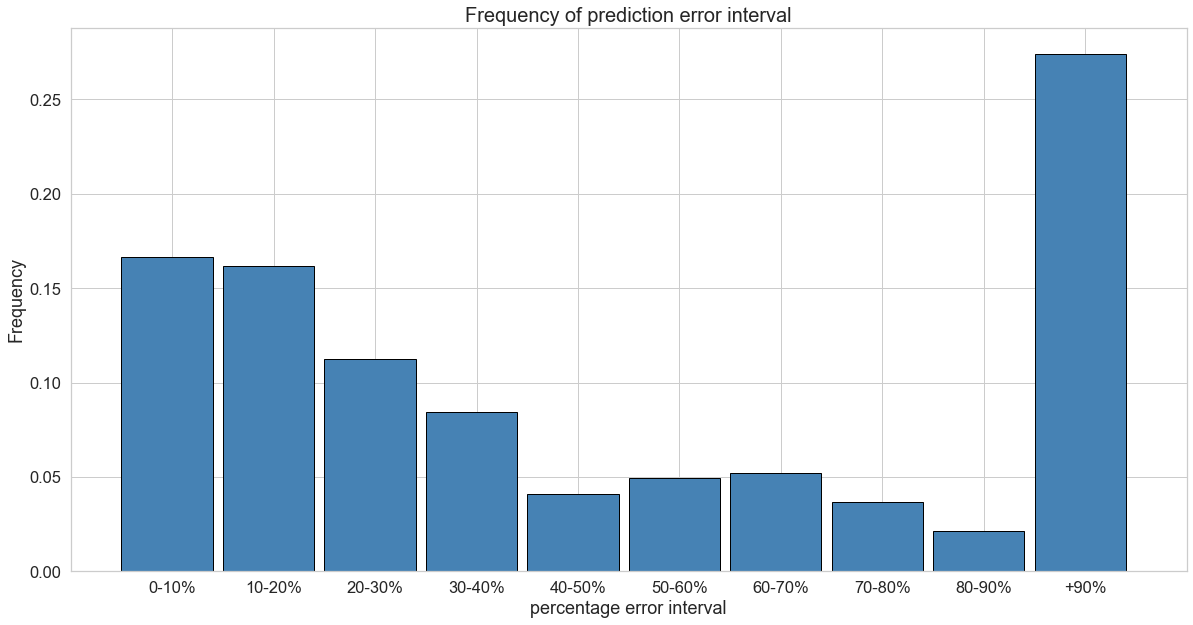

number of errors greater than 50% = 201 out of 463 predictions
the mean percentage error = 76 %


In [144]:
sns.set(style='whitegrid',font_scale=1.5)

bins=np.arange(1,12,1)
prediction['percentage error discrete'].plot(kind='hist',
                                             bins=bins,width=0.9,
                                             align='left',
                                             density=True,
                                             figsize=(20,10),
                                             ec='black',
                                             color='steelblue')

labels=[str(i)+'-'+str(j)+'%' for i,j in zip(np.arange(0,90,10),np.arange(10,100,10))]
labels.append('+90%')
plt.xticks(np.arange(1,12,1),labels=labels)
plt.xlabel('percentage error interval')
plt.ylabel('Frequency')
plt.title('Frequency of prediction error interval',fontsize=20)
plt.show()

try:
    greater50=np.unique(np.where(abs(prediction['percentage error [%]'].values)>=50,1,0),return_counts=True)[1][1]
    print('number of errors greater than 50% = {} out of {} predictions'.format(greater50,X_test.shape[0]))
except:
    print("There is no error greater than 50%")


print('the mean percentage error = {} %'.format( round(prediction['percentage error [%]'].abs().mean()),2))

Residual plots

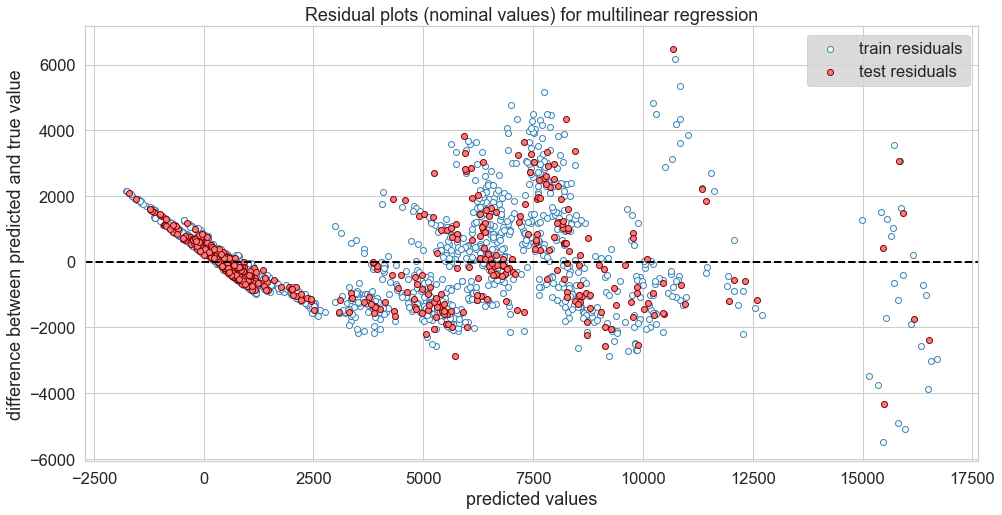

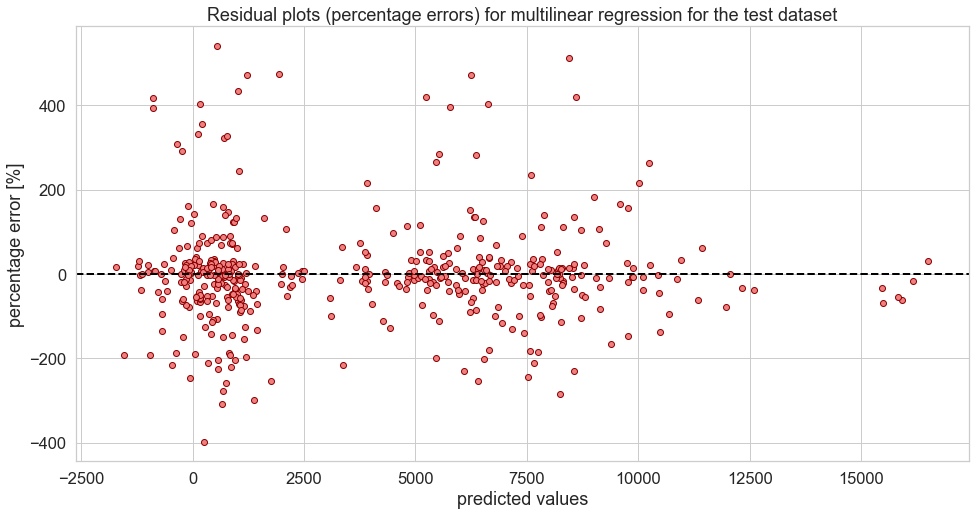

In [145]:
fig,ax=plt.subplots(figsize=(16,8))

residuals_train=y_train-y_train_predicted
residuals_test=y_test-y_test_predicted

ax.scatter(y_train_predicted,residuals_train,color='Azure',ec='steelblue',label='train residuals')
ax.scatter(y_test_predicted,residuals_test,color='LightCoral',ec='darkred',label='test residuals')
ax.axhline(y=0,lw=2,ls='--',color='black')
ax.set(xlabel='predicted values',ylabel='difference between predicted and true value')
ax.legend(frameon=True,facecolor='LightGray')
ax.set_title('Residual plots (nominal values) for multilinear regression')
plt.show()

fig,ax=plt.subplots(figsize=(16,8))

ax.scatter(y_test_predicted,prediction['percentage error [%]'],color='LightCoral',ec='darkred')
ax.axhline(y=0,lw=2,ls='--',color='black')
ax.set(xlabel='predicted values',ylabel='percentage error [%]')
ax.set_title('Residual plots (percentage errors) for multilinear regression for the test dataset')
plt.show()

Probability plot of residuals against the quantiles

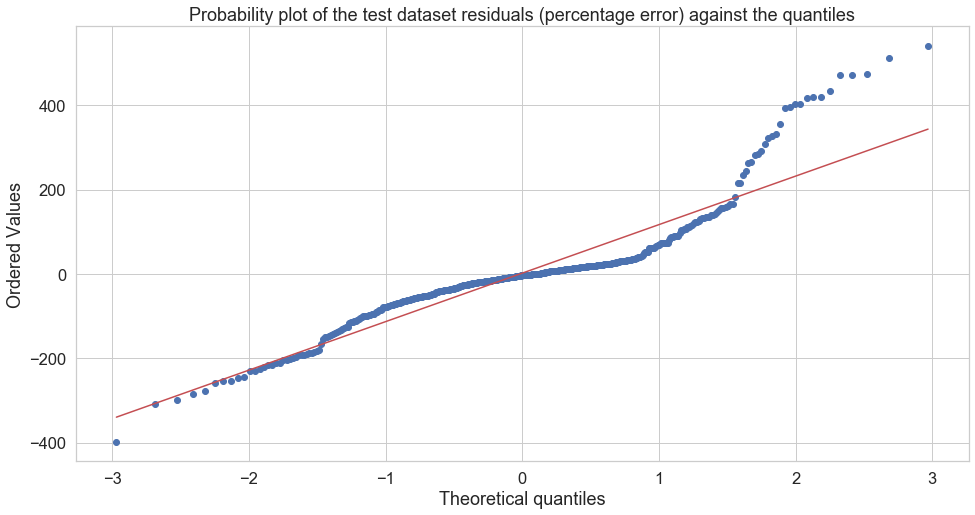

In [146]:
fig,ax=plt.subplots(figsize=(16,8))
probplot(prediction['percentage error [%]'], dist='norm', fit=True, plot=ax, rvalue=False)
ax.set_title('Probability plot of the test dataset residuals (percentage error) against the quantiles')
ax.grid(b=True)
plt.show()

Predicted and true prices in function of time

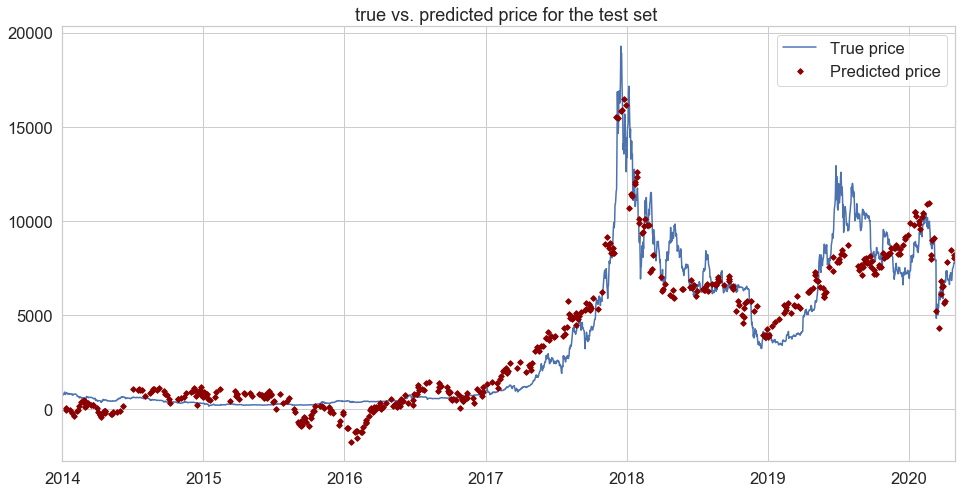

In [147]:
datemin = datetime.date(data.index.min().year, data.index.min().day-1, 1)
datemax = datetime.date(data.index.max().year, data.index.max().month + 1, 1)

plt.figure(figsize=(16,8))
plt.plot(data.index,data['BTC price [USD]'],'-',label='True price')
plt.plot(prediction.index,prediction['predicted price'],'D',markersize=4,color='darkred',label='Predicted price')
plt.grid(b=True)
plt.title('true vs. predicted price for the test set ')
plt.xlim([datemin,datemax])
plt.legend()
plt.show()

Deeper insight into model using statsmodels library 

In [148]:
X_train_sm, X_test_sm = X_train, X_test
X_train_sm=sm.add_constant(X_train_sm)
X_test_sm=sm.add_constant(X_test_sm)
lr_sm = sm.OLS(y_train, X_train_sm)
lr_sm.fit().summary()

C:\Users\Bonias\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BTC price [USD]   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     4044.
Date:                Thu, 18 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:32:51   Log-Likelihood:                -15793.
No. Observations:                1850   AIC:                         3.160e+04
Df Residuals:                    1845   BIC:                         3.162e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.729e+04    360.366    -47.990      0.000    -1.8e+04   -1.66e+04
n-transactions       -0.0058      0.000    -12.716      0.000      -0.007      -0.005
btc search trends   127.5400      2.342     54.460      0.000     122.947     132.133
Gold price[USD]       3.4256      0.323     10.605      0.000       2.792       4.059
SP500 close index     6.7305      0.126     53.391      0.000       6.483       6.978
==============================================================================
Omnibus:                      274.155   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.185
Skew:                           0.846   Prob(JB):                    6.43e-137
Kurtosis:                       5.297   Cond. No.                     2.94e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 2. Polynomial regression

In order to evaluate polynominal regression transformed versions of the predictors are added to the model. The model is in the form:
$$ Y=X+\sqrt{X} + X^2 + X^3 $$

In [149]:
X_nonlinear=X.copy()
scale=['square root','squared','cubed']
scale_num=[0.5,2,3]
for i in X_nonlinear.columns:
    for j,k in zip(scale,scale_num):
        name = j + " " + str(i)  
        X_nonlinear[name]=X_nonlinear[i]**k
X_nonlinear.head()

,n-transactions,btc search trends,Gold price[USD],SP500 close index,square root n-transactions,squared n-transactions,cubed n-transactions,square root btc search trends,squared btc search trends,cubed btc search trends,square root Gold price[USD],squared Gold price[USD],cubed Gold price[USD],square root SP500 close index,squared SP500 close index,cubed SP500 close index
Date,,,,,,,,,,,,,,,,
2014-01-02,54770.0,8,1225.0,1831.98,234.029913,2.999753e+09,1.642965e+14,2.828427,64,512,35.000000,1500625.00,1.838266e+09,42.801635,3.356151e+06,6.148401e+09
2014-01-03,60980.0,8,1238.4,1831.37,246.941289,3.718560e+09,2.267578e+14,2.828427,64,512,35.190908,1533634.56,1.899253e+09,42.794509,3.353916e+06,6.142261e+09
2014-01-04,52052.0,8,1238.4,1831.37,228.149074,2.709411e+09,1.410302e+14,2.828427,64,512,35.190908,1533634.56,1.899253e+09,42.794509,3.353916e+06,6.142261e+09
2014-01-05,58662.0,8,1238.4,1831.37,242.202395,3.441230e+09,2.018694e+14,2.828427,64,512,35.190908,1533634.56,1.899253e+09,42.794509,3.353916e+06,6.142261e+09
2014-01-06,67358.0,8,1237.8,1826.77,259.534198,4.537100e+09,3.056100e+14,2.828427,64,512,35.182382,1532148.84,1.896494e+09,42.740730,3.337089e+06,6.096093e+09


In [150]:
X_train_nl, X_test_nl, y_train, y_test = train_test_split(X_nonlinear,y,train_size=0.8, shuffle=True)

In [151]:
lr_nl=LinearRegression()
lr_nl.fit(X_train_nl,y_train)
y_train_predicted_nl=lr_nl.predict(X_train_nl)
y_test_predicted_nl=lr_nl.predict(X_test_nl)
RMSE_train_nl=mean_squared_error(y_train,y_train_predicted_nl,squared=False)
RMSE_test_nl=mean_squared_error(y_test,y_test_predicted_nl,squared=False)
R2_train_nl=r2_score(y_train,y_train_predicted_nl)
print('Train set: RMSE={}, R2={}'.format(round(RMSE_train_nl,2),round(R2_train_nl,4)))
print('Test set: RMSE={}'.format(round(RMSE_test_nl,2)))

Train set: RMSE=1234.73, R2=0.899
Test set: RMSE=1217.63


In [152]:
prediction_nl=pd.DataFrame(data=np.hstack( (y_test.values.reshape(-1,1),y_test_predicted_nl.reshape(-1,1))),
             columns=['true price','predicted price'],
            index=y_test.index)
prediction_nl.sort_index(inplace=True)
prediction_nl['percentage error [%]']=100*(prediction_nl.iloc[:,0]-prediction_nl.iloc[:,1])/prediction_nl.iloc[:,0]
prediction_nl['percentage error discrete']=prediction_nl['percentage error [%]'].apply(percentage_discrete)
prediction_nl.head(10)

,true price,predicted price,percentage error [%],percentage error discrete
Date,,,,
2014-01-07,915.69,-389.325830,142.517209,10
2014-01-10,826.28,-314.945361,138.116058,10
2014-01-16,841.83,-308.706622,136.670898,10
2014-01-17,817.15,-327.414572,140.067867,10
2014-01-19,811.20,-328.687063,140.518622,10
2014-02-01,803.00,-648.425509,180.750375,10
2014-02-06,781.00,-676.317255,186.596320,10
2014-02-07,763.97,-511.747821,166.985329,10
2014-02-09,680.80,-498.393206,173.206993,10


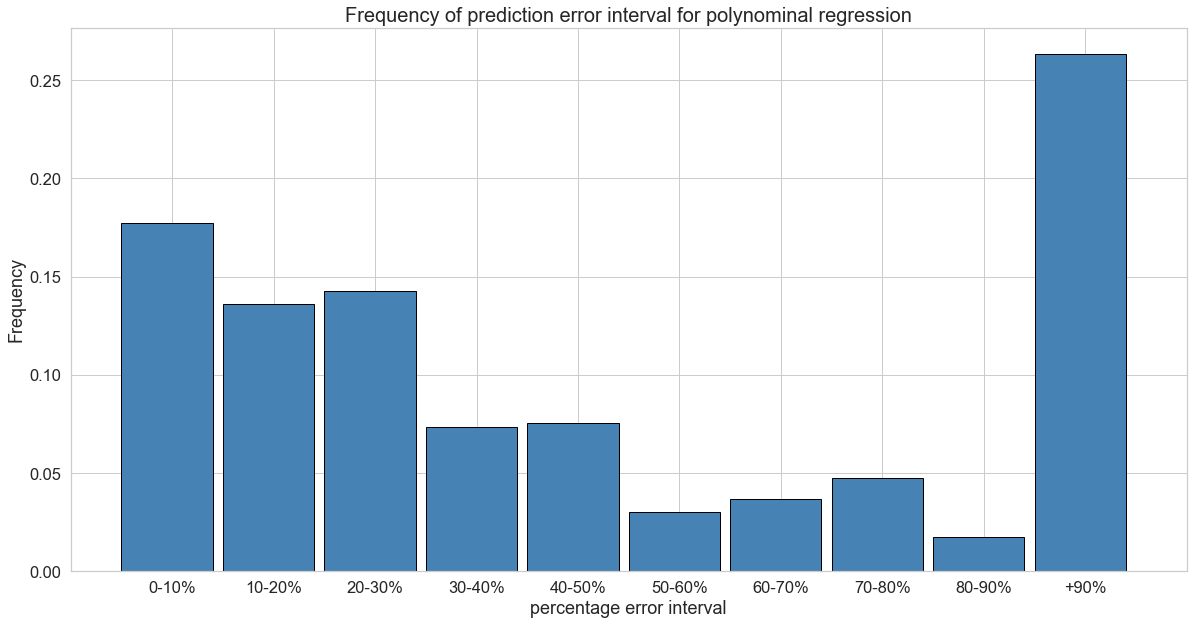

number of errors greater than 50% = 183 out of 463 predictions
the mean percentage error = 76.3159169132952


In [153]:
sns.set(style='whitegrid',font_scale=1.5)

bins=np.arange(1,12,1)
prediction_nl['percentage error discrete'].plot(kind='hist',
                                             bins=bins,width=0.9,
                                             align='left',
                                             density=True,
                                             figsize=(20,10),
                                             ec='black',
                                             color='steelblue')

labels=[str(i)+'-'+str(j)+'%' for i,j in zip(np.arange(0,90,10),np.arange(10,100,10))]
labels.append('+90%')
plt.xticks(np.arange(1,12,1),labels=labels)
plt.xlabel('percentage error interval')
plt.ylabel('Frequency')
plt.title('Frequency of prediction error interval for polynominal regression',fontsize=20)
plt.show()

try:
    greater50=np.unique(np.where(abs(prediction_nl['percentage error [%]'].values)>=50,1,0),return_counts=True)[1][1]
    print('number of errors greater than 50% = {} out of {} predictions'.format(greater50,X_test_nl.shape[0]))
except:
    print("There is no error greater than 50%")


print('the mean percentage error = {}'.format(prediction['percentage error [%]'].abs().mean()))

Because the results obtained using polynominal regression hardly differ from the results obtained using multilinear regression further investigation is not necessary

### Summary:

1. In this notebook two regression models were evaluated
    - mulitilinear regression model
    - polynominal regression model
    <br> The results obtained by these models are almost the same but the polynominal regression is slightly better 

2. Although residual plot (of percentage error in multilinear regression) don't yield any noticable pattern and $ R^2 $ factor is quite high the values of residuals are huge what make this model useless.
3. Probability plot of the test dataset residuals is not placed along the red line at all what suggest that the model is incorrect 
4. RMSE equals $ \approx 1200 $  what is a meaningul fraction of the current bitcoin price (17.06.2020) as well as the all time high price. Mean percentage error equals $ \approx 80\% $ what contributes to uselessness of this model as well.
5. The models predict negative prices what is senseless


### Conclusion

Regression is not a useful method for predicting the price of bitcoin.

